In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import obspy
from obspy.clients.fdsn import Client

c = Client("IRIS")

In [7]:
file = '/data/crowsnest/Datasets/TA_Data/USArray_07-13.zip'
df = pd.read_pickle(file)

In [8]:
def download_waveforms(time, sta, pre, post, fs=40, client=c):
    ''' 
    Download a waveform window around a specific timestamp
    time: timestamp of arrival in yyyy-mm-dd HH:mm:ss.ff
    sta:  seismic station name
    pre:  window length prior to arrival in seconds
    post: window length after arrival in seconds
    '''
    
    time = obspy.UTCDateTime(time)
    st_time = time - pre
    en_time = time + post
    
    try:
        arrival_window = client.get_waveforms(network="*", location="",
                                                   station=sta, channel="BHZ",
                                                   starttime=st_time, endtime=en_time)[0]
    except:
        pass
    
    if len(arrival_window) != (pre + post) * fs:
        arrival_window = None
    
    return arrival_window

In [11]:
my_df = df[df.DIST < 5].sample(200)

pre_win   = 0  # window length prior to arrival in seconds
post_win  = 120  # window length after arrival in seconds
samp_rate = 40  # sample rate in hertz
     
dat = []
for row, arrival in my_df.iterrows():

    arrival_window = download_waveforms(arrival.TIME, arrival.STA, pre=pre_win, post=post_win, fs=samp_rate)
    if arrival_window: dat.append(arrival_window)

dat = np.vstack(dat)
np.save('seismic_waveforms.npy', dat)

In [12]:
dat = np.load('seismic_waveforms.npy')

In [13]:
def gap_generator(dat, bs, win_len, gap_len, fs):
    ''' 
    Build a batch of waveforms with gaps
    data:    numpy array with raw data
    bs:      batch size to be generated
    win_len: window length of each example in seconds
    gap_len: gap length in seconds
    fs:      sample rate of signal in hertz
    '''
    tot_len = dat.shape[1]
    dat = dat - np.expand_dims(np.mean(dat,axis=1),1)
    dat = dat / np.expand_dims(np.max(dat,axis=1),1)
    while 1:
        
        my_indicies = np.random.randint(len(dat), size=bs)
        my_win_st = np.random.randint(tot_len - win_len * fs)
        my_win_en = my_win_st + win_len * fs
        my_y = dat[my_indicies, my_win_st:my_win_en]

        my_x = my_y.copy()
        my_gap_st = int((win_len - gap_len) * fs / 2)
        my_gap_en = my_gap_st + gap_len * fs
        my_x[:, my_gap_st:my_gap_en] = 0

        yield my_x, my_y

In [17]:
batch_size = 4
window_len = 30
gap_len = 1
NFFT = 256

trn_gen = gap_generator(dat, bs=batch_size, win_len=window_len, gap_len=gap_len, fs=samp_rate)

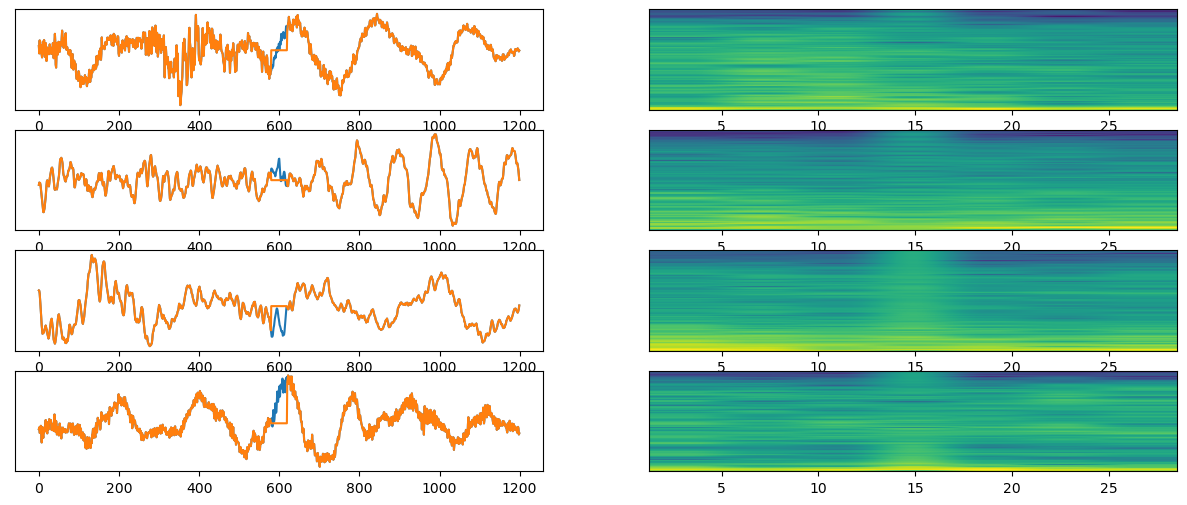

In [37]:
x, y = next(trn_gen)

fig, ax = plt.subplots(batch_size, 2, figsize=(15,batch_size*1.5))

for i in range(len(x)):
    ax[i,0].plot(y[i])
    ax[i,0].plot(x[i])
    ax[i,0].get_yaxis().set_ticks([])
    ax[i,1].specgram(x[i], NFFT=NFFT, Fs=samp_rate, noverlap=100)
    ax[i,1].get_yaxis().set_ticks([])

plt.savefig('gaps.jpg')
plt.show()